### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_colwidth", None)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
model = XLMRobertaModel.from_pretrained("xlm-roberta-base").to(device)

### Import Dataset

In [3]:
df_en = pd.read_csv("../../data/english_only_data.csv")
df_ko = pd.read_csv("../../data/korean_only_data.csv")

In [4]:
df_en["language"] = "en"
df_ko["language"] = "ko"

df = pd.concat([df_en, df_ko], ignore_index=True)
df = shuffle(df, random_state=70)
df.head(10)

,Comment,Sentiment,language
133506,맛있고 분위기도 좋아요! 야외에서도 식사 가능해서 날씨 좋으면 더 좋아요,positive,ko
189273,어느 수산시장에서나 나오면 먹을 수 있는 민어.의 맛집 서비스 업종 역사상 최악 ...,negative,ko
2925,wow wow! what a funky little fleet!!! too sassy,Positive,en
41958,The invention original purpose is the most Bri...,Positive,en
104357,양도 푸짐하고 소스 모자라면 리필도 가능해서 좋아요. 한 명이 먹기에는 좀 많은 양...,positive,ko
32398,I feel sorry for this guy because you can tell...,Negative,en
158051,맛의 고장에 이런 식당이 있는 게 불가사의함..,negative,ko
81396,I've never heard someone talk so beautifully a...,Positive,en
156946,평점 0점은 왜 없는 거죠... 맛 집이라 해서 꾸불꾸불 산길을 비포장도로 따라 내...,negative,ko
108275,솔직히 별 하나도 아깝네요. 팥빙수라고 시켰는데 우유도 아니고 연유로 범벅을 해 가...,negative,ko


In [5]:
df.shape

(200000, 3)

In [6]:
df["Sentiment"] = df["Sentiment"].map({"Negative": 0, "Positive": 1, "negative": 0, "positive": 1}).astype(int)

In [7]:
df_copy = df.copy()

In [8]:
def preprocess_text(texts, tokenizer, max_len=10):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoding["input_ids"])
        attention_masks.append(encoding["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [10]:
def get_embeddings(input_ids, attention_masks, model, batch_size=16, device=device):
    dataset = TensorDataset(input_ids, attention_masks)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    all_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            batch_input_ids = batch[0].to(device)
            batch_attention_masks = batch[1].to(device)
            outputs = model(
                input_ids=batch_input_ids, attention_mask=batch_attention_masks
            )
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings.cpu().numpy())
    return np.vstack(all_embeddings)

In [11]:
def vectorize_and_split(df, test_size, lang):
    X = df["Comment"]
    y = df["Sentiment"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    train_input_ids, train_attention_masks = preprocess_text(X_train, tokenizer)
    test_input_ids, test_attention_masks = preprocess_text(X_test, tokenizer)

    train_embeddings = get_embeddings(train_input_ids, train_attention_masks, model)
    test_embeddings = get_embeddings(test_input_ids, test_attention_masks, model)

    np.save(f"../../model/{lang}_bert_train_embeddings.npy", train_embeddings)
    np.save(f"../../model/{lang}_bert_test_embeddings.npy", test_embeddings)
    np.savez(
        f"../../model/{lang}_train_test_labels.npz",
        y_train=y_train.to_numpy(),
        y_test=y_test.to_numpy(),
    )

    return train_embeddings, test_embeddings, y_train, y_test

In [12]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    print(f"{'-'*40} {model_name} {'-'*40}")
    model.fit(X_train, y_train)
    results = []
    for mode, X, y in [("Test", X_test, y_test), ("Train", X_train, y_train)]:
        y_pred = model.predict(X)
        print(f"\n{mode} Classification Report:\n")
        print(classification_report(y, y_pred))

        ConfusionMatrixDisplay.from_estimator(
            model, X, y, display_labels=["Negative", "Positive"], cmap="Blues"
        )
        plt.title(f"{model_name} Confusion Matrix ({mode} Set)")
        plt.show()

        report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        acc = accuracy_score(y, y_pred)
        results.append(
            {
                "Model": model_name,
                "Dataset": mode,
                "Accuracy": acc,
                "Precision": report["weighted avg"]["precision"],
                "Recall": report["weighted avg"]["recall"],
                "F1-Score": report["weighted avg"]["f1-score"],
            }
        )
    return results

In [13]:
def run_all_models(X_train, X_test, y_train, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM": LinearSVC(),
    }
    all_results = []
    for name, model in models.items():
        results = train_and_evaluate(model, X_train, X_test, y_train, y_test, name)
        all_results.extend(results)
    return all_results

In [14]:
def train_models(df, language):
    print(f"\n{'-'*40} {language} {'-'*40}")
    lang_map = {"English + Korean": "both", "Korean": "ko", "English": "en"}
    X_train, X_test, y_train, y_test = vectorize_and_split(df, 0.2, lang_map[language])
    results = run_all_models(X_train, X_test, y_train, y_test)
    for r in results:
        r["Language"] = language
    return pd.DataFrame(results)


---------------------------------------- English + Korean ----------------------------------------


Extracting embeddings: 100%|██████████| 2500/2500 [02:48<00:00, 14.88it/s]


---------------------------------------- Logistic Regression ----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.75      0.74     20063
           1       0.75      0.73      0.74     19937

    accuracy                           0.74     40000
   macro avg       0.74      0.74      0.74     40000
weighted avg       0.74      0.74      0.74     40000



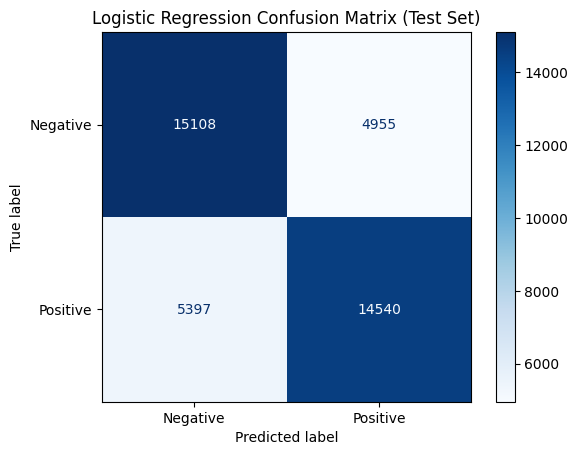


Train Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.75      0.74     79937
           1       0.75      0.73      0.74     80063

    accuracy                           0.74    160000
   macro avg       0.74      0.74      0.74    160000
weighted avg       0.74      0.74      0.74    160000



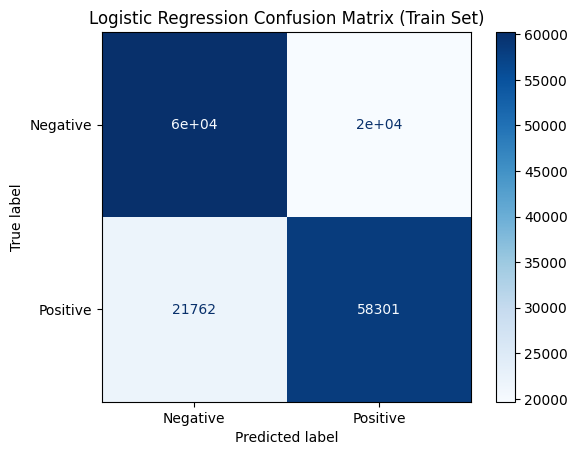

---------------------------------------- SVM ----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.76      0.75     20063
           1       0.75      0.73      0.74     19937

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



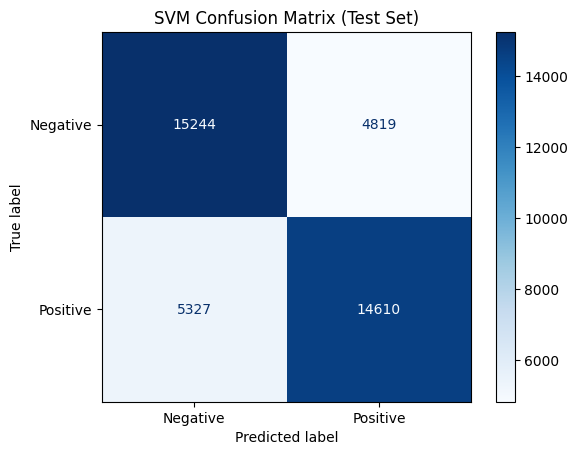


Train Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.76      0.75     79937
           1       0.75      0.73      0.74     80063

    accuracy                           0.75    160000
   macro avg       0.75      0.75      0.75    160000
weighted avg       0.75      0.75      0.75    160000



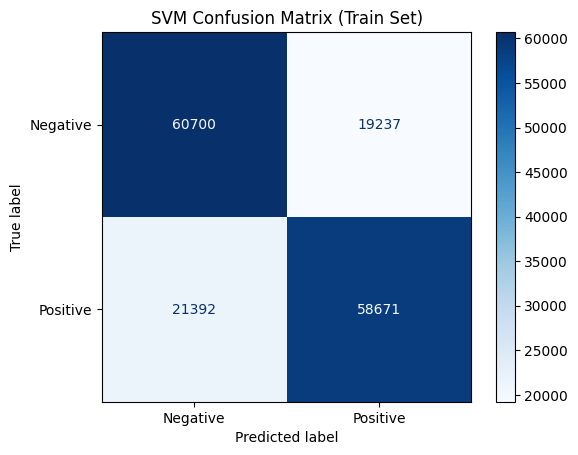

In [15]:
results_all = train_models(df, "English + Korean")


---------------------------------------- Korean ----------------------------------------


Extracting embeddings: 100%|██████████| 1250/1250 [01:19<00:00, 15.78it/s]


---------------------------------------- Logistic Regression ----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     10108
           1       0.74      0.77      0.76      9892

    accuracy                           0.75     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.76      0.75      0.75     20000



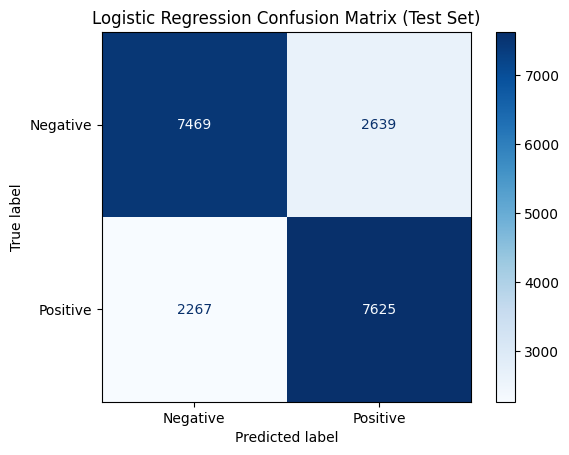


Train Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     39892
           1       0.75      0.77      0.76     40108

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000



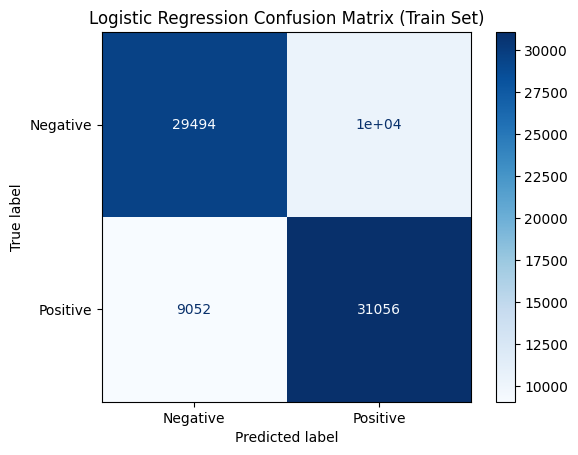

---------------------------------------- SVM ----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     10108
           1       0.76      0.79      0.77      9892

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



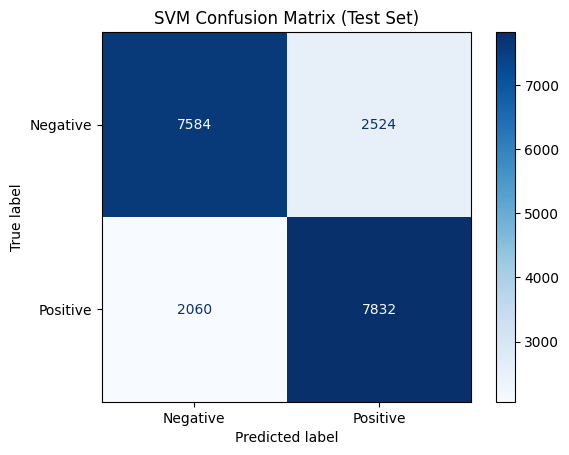


Train Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.75      0.77     39892
           1       0.76      0.80      0.78     40108

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000



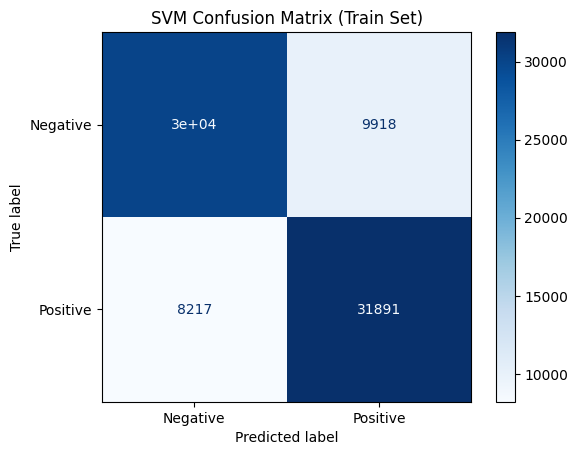

In [17]:
results_ko = train_models(df_copy[df_copy["language"] == "ko"], "Korean")


---------------------------------------- English ----------------------------------------


Extracting embeddings: 100%|██████████| 1250/1250 [01:28<00:00, 14.07it/s]


---------------------------------------- Logistic Regression ----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.79      0.76     10035
           1       0.77      0.71      0.74      9965

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



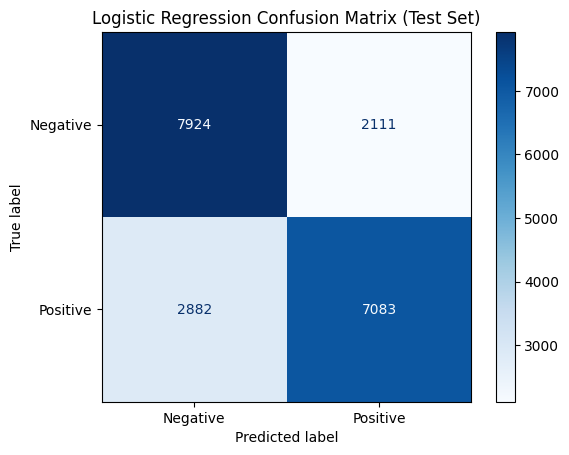


Train Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.79      0.76     39965
           1       0.77      0.71      0.74     40035

    accuracy                           0.75     80000
   macro avg       0.75      0.75      0.75     80000
weighted avg       0.75      0.75      0.75     80000



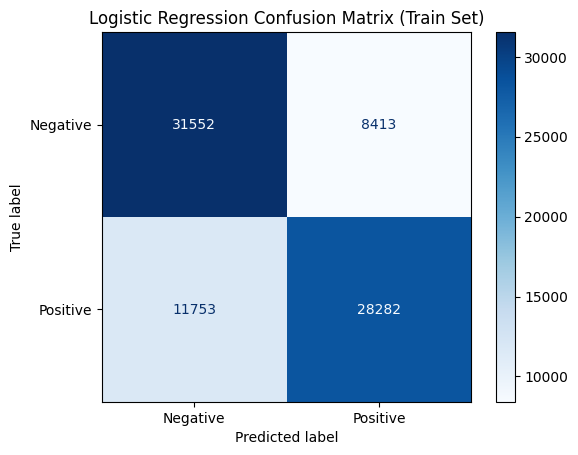

---------------------------------------- SVM ----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.80      0.76     10035
           1       0.78      0.71      0.74      9965

    accuracy                           0.75     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.76      0.75      0.75     20000



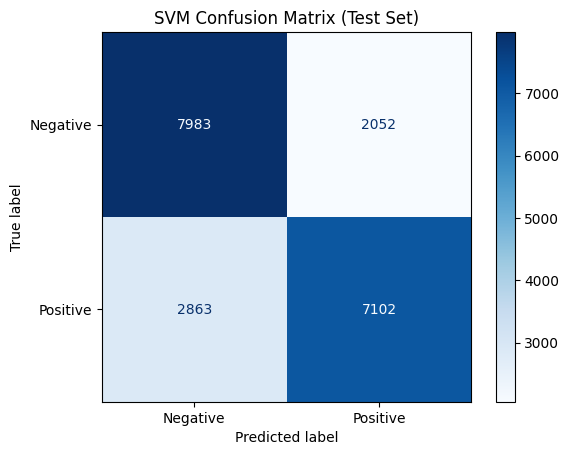


Train Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.80      0.76     39965
           1       0.78      0.71      0.74     40035

    accuracy                           0.75     80000
   macro avg       0.75      0.75      0.75     80000
weighted avg       0.75      0.75      0.75     80000



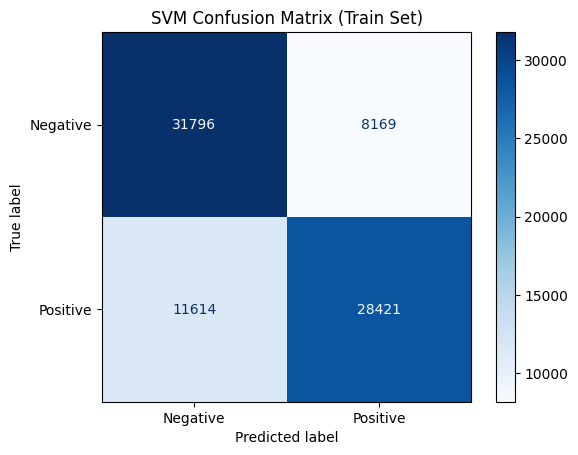

In [18]:
results_en = train_models(df_copy[df_copy["language"] == "en"], "English")

## Comparing

In [21]:
all_results_df = pd.concat([results_all, results_en, results_ko], ignore_index=True)
print("FINAL COMPARISON SUMMARY")
print(tabulate(all_results_df.reset_index(drop=True), headers="keys", tablefmt="psql"))

FINAL COMPARISON SUMMARY
+----+---------------------+-----------+------------+-------------+----------+------------+------------------+
|    | Model               | Dataset   |   Accuracy |   Precision |   Recall |   F1-Score | Language         |
|----+---------------------+-----------+------------+-------------+----------+------------+------------------|
|  0 | Logistic Regression | Test      |   0.7412   |    0.7413   | 0.7412   |   0.741159 | English + Korean |
|  1 | Logistic Regression | Train     |   0.740919 |    0.741086 | 0.740919 |   0.740878 | English + Korean |
|  2 | SVM                 | Test      |   0.74635  |    0.746489 | 0.74635  |   0.746299 | English + Korean |
|  3 | SVM                 | Train     |   0.746069 |    0.746253 | 0.746069 |   0.746025 | English + Korean |
|  4 | Logistic Regression | Test      |   0.75035  |    0.75178  | 0.75035  |   0.749945 | English          |
|  5 | Logistic Regression | Train     |   0.747925 |    0.749684 | 0.747925 |   0.7474

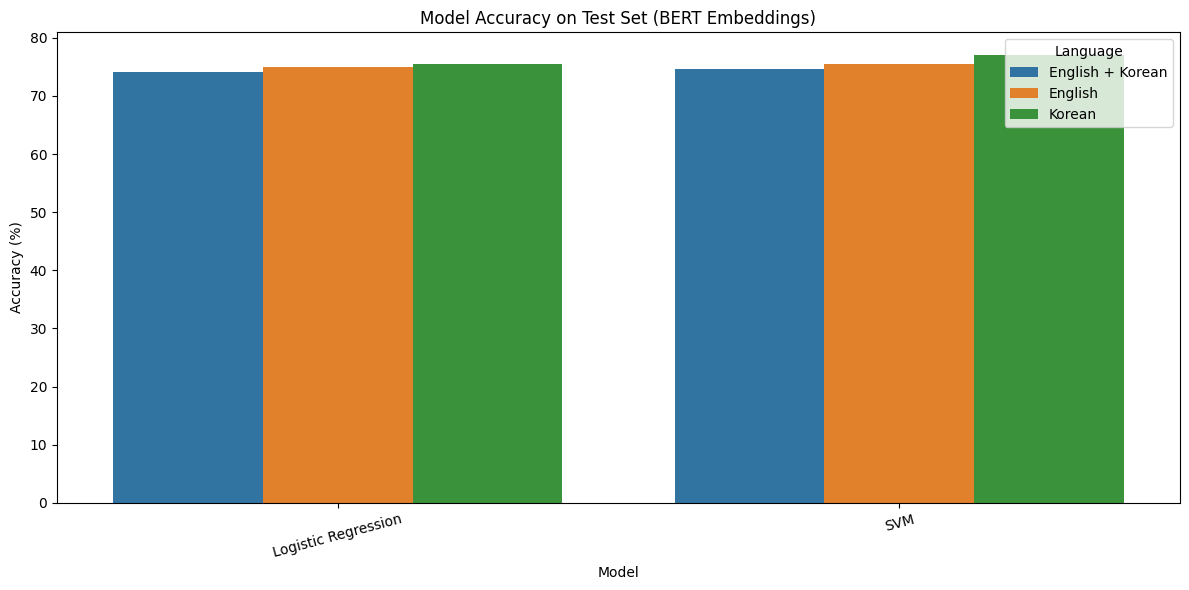

In [22]:
plt.figure(figsize=(12, 6))
subset = all_results_df[all_results_df["Dataset"] == "Test"].copy()
subset["Accuracy_percent"] = subset["Accuracy"] * 100

sns.barplot(
    data=subset,
    x="Model",
    y="Accuracy_percent",
    hue="Language",
)
plt.title("Model Accuracy on Test Set (BERT Embeddings)")
plt.ylabel("Accuracy (%)")
plt.legend(title="Language")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()